## 逻辑回归
在训练的初始阶段，我们将要构建一个逻辑回归模型来预测，某个学生是否被大学录取。设想你是大学相关部分的管理者，想通过申请学生两次测试的评分，来决定他们是否被录取。现在你拥有之前申请学生的可以用于训练逻辑回归的训练样本集。对于每一个训练样本，你有他们两次测试的评分和最后是被录取的结果。为了完成这个预测任务，我们准备构建一个可以基于两次测试评分来评估录取可能性的分类模型。

In [92]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
score_df = pd.read_csv('ex2data1.txt', names=['exam1', 'exam2', 'accepted'])

In [94]:
score_df.head()

,exam1,exam2,accepted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


让我们创建两个分数的散点图，并使用颜色编码来可视化，如果样本是正的（被接纳）或负的（未被接纳）。

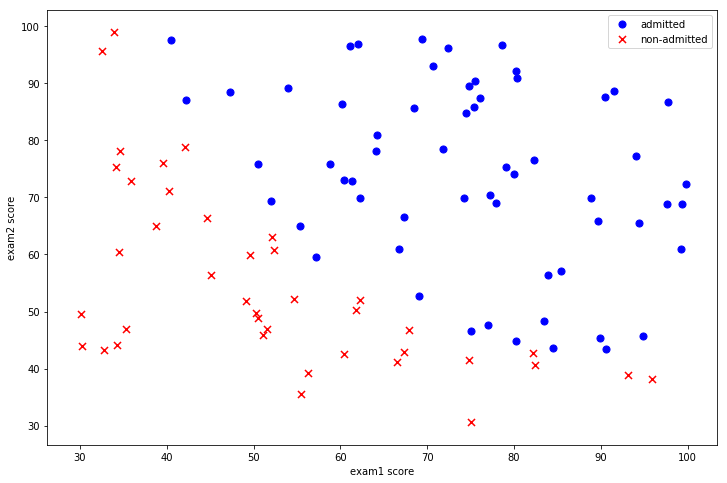

In [95]:
positive = score_df[score_df['accepted'].isin([1])]
negative = score_df[score_df['accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(positive.exam1, positive.exam2, s=50, c='b', marker='o', label='admitted')
ax.scatter(negative.exam1, negative.exam2, s=50, c='r', marker='x', label='non-admitted')
ax.legend()
ax.set_xlabel('exam1 score')
ax.set_ylabel('exam2 score')
plt.show()

### sigmoid 函数
g 代表一个常用的逻辑函数（logistic function）为S形函数（Sigmoid function），公式为：$$g\left( z \right)=\frac{1}{1+{{e}^{-z}}}$$合起来，我们得到逻辑回归模型的假设函数：$${{h}_{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$$

In [96]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

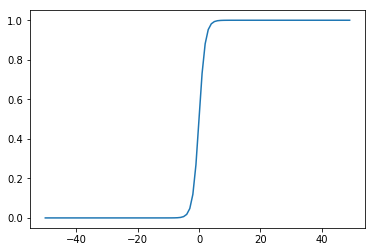

In [97]:
# 检查函数形状

test = np.arange(-50, 50)
s = sigmoid(test)
plt.plot(test, s)
plt.show()

代价函数： $J\left( \theta \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}$

In [98]:
def cost(theta, X, y):
    # 定义逻辑回归的代价函数
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    first = np.multiply(-y, np.log(sigmoid(X@theta.T)))
    second = np.multiply(-(1-y), np.log(1-sigmoid(X@theta.T)))
    
    return np.sum((first + second)/ len(X))
    

In [99]:
if 'ones' in score_df:
    pass
else:
    # 添加一列,使后续操作可以实现向量化操作
    score_df.insert(0, 'ones', 1)
    
# 设置变量
X = score_df.iloc[:, :-1].values
y = score_df.iloc[:, -1:].values
theta = np.zeros(X.shape[1])

In [100]:
X.shape, y.shape, theta.shape

((100, 3), (100, 1), (3,))

让我们计算初始化参数的代价函数(theta为0)。

In [101]:
cost(theta, X, y)

0.6931471805599457

## gradient descent(梯度下降)
这是批量梯度下降（batch gradient descent）
转化为向量化计算： $\frac{1}{m} X^T( Sigmoid(X\theta) - y )$ 
$$\frac{\partial J\left( \theta \right)}{\partial {{\theta }_{j}}}=\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{_{j}}^{(i)}}$$

In [102]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X * theta.T) - y
    for i in range(parameters):
        term = np.multiply(error, X[:, i])
        grad[i] = np.sum(term) / len(X)
    return grad

注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算一个梯度步长。在练习中，一个称为“fminunc”的Octave函数是用来优化函数来计算成本和梯度参数。由于我们使用Python，我们可以用SciPy的“optimize”命名空间来做同样的事情。

我们看看用我们的数据和初始参数为0的梯度下降法的结果。

In [103]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

现在可以用SciPy's truncated newton（TNC）实现寻找最优参数。

In [104]:
import scipy.optimize as opt

res = opt.fmin_tnc(func=cost, x0=theta, args=(X, y), fprime=gradient)
res

(array([-25.16131868,   0.20623159,   0.20147149]), 36, 0)

In [105]:
cost(res[0], X, y)

0.2034977015894744

接下来，我们需要编写一个函数，用我们所学的参数theta来为数据集X输出预测。然后，我们可以使用这个函数来给我们的分类器的训练精度打分。 逻辑回归模型的假设函数： ${{h}{\theta }}\left( x \right)=\frac{1}{1+{{e}^{-{{\theta }^{T}}X}}}$ 

当${{h}_{\theta }}$大于等于0.5时，预测 y=1

当${{h}_{\theta }}$小于0.5时，预测 y=0 。



In [106]:
def predict(X, theta):
    
    # 可能性
    probability = sigmoid(X @ theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]


In [107]:
theta_min = res[0]  # 求出的theta

predictions = predict(theta_min, X)
print(predictions)
correct = [1 if ((a==1 and b==1) or (a==0 and b==0)) else 0 for (a, b) in zip(predictions, y)]

# 准确率  因为correc中1位正确，0错误，所以可以这样求和算准确率
accuracy =sum(correct) / len(correct)

print('accuracy:{}'.format(accuracy))

[0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]
accuracy:0.89


我们的逻辑回归分类器预测正确，如果一个学生被录取或没有录取，达到89%的精确度。不坏！记住，这是训练集的准确性。我们没有保持住了设置或使用交叉验证得到的真实逼近，所以这个数字有可能高于其真实值（这个话题将在以后说明）。

## 正则化逻辑回归
在训练的第二部分，我们将要通过加入正则项提升逻辑回归算法。如果你对正则化有点眼生，或者喜欢这一节的方程的背景，请参考在"exercises"文件夹中的"ex2.pdf"。简而言之，正则化是成本函数中的一个术语，它使算法更倾向于“更简单”的模型（在这种情况下，模型将更小的系数）。这个理论助于减少过拟合，提高模型的泛化能力。这样，我们开始吧。

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

和第一部分很像，从数据可视化开始吧！

In [108]:
data = pd.read_csv('ex2data2.txt', names=['test1', 'test2', 'accepted'])
data.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


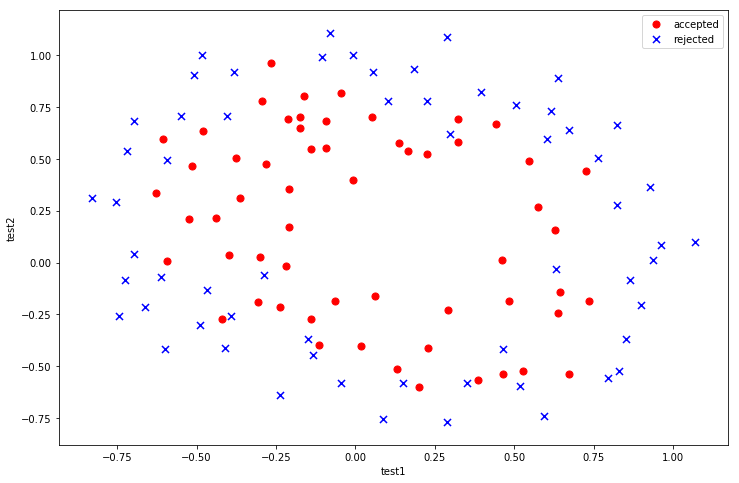

In [109]:
positive = data[data.accepted.isin([1])]
negative = data[data.accepted.isin([0])]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter('test1', 'test2', data=positive, s=50, c='r', marker='o', label='accepted')
ax.scatter('test1', 'test2', data=negative, s=50, c='b', marker='x', label='rejected')
ax.legend()
ax.set_xlabel('test1')
ax.set_ylabel('test2')
plt.show()

哇，这个数据看起来可比前一次的复杂得多。特别地，你会注意到其中没有线性决策界限，来良好的分开两类数据。一个方法是用像逻辑回归这样的线性技术来构造从原始特征的多项式中得到的特征。让我们通过创建一组多项式特征入手吧。

In [110]:
degress = 5
x1 = data['test1']
x2 = data['test2']

if 'ones' not in data:
    data.insert(3, 'ones', 1)
for i in range(degress):
    for j in range(i):
        data['F' + str(i) + str(j)] = np.power(x1, i-j) * np.power(x2, j)
        
data.drop('test1', axis=1, inplace=True)
data.drop('test2', axis=1, inplace=True)
data.head()

,accepted,ones,F10,F20,F21,F30,F31,F32,F40,F41,F42,F43
0,1,1,0.051267,0.002628,0.035864,0.000135,0.001839,0.025089,0.000007,0.000094,0.001286,0.017551
1,1,1,-0.092742,0.008601,-0.063523,-0.000798,0.005891,-0.043509,0.000074,-0.000546,0.004035,-0.029801
2,1,1,-0.213710,0.045672,-0.147941,-0.009761,0.031616,-0.102412,0.002086,-0.006757,0.021886,-0.070895
3,1,1,-0.375000,0.140625,-0.188321,-0.052734,0.070620,-0.094573,0.019775,-0.026483,0.035465,-0.047494
4,1,1,-0.513250,0.263426,-0.238990,-0.135203,0.122661,-0.111283,0.069393,-0.062956,0.057116,-0.051818


现在，我们需要修改第1部分的成本和梯度函数，包括正则化项。首先是成本函数：

## regularized cost（正则化代价函数）
$$J\left( \theta \right)=\frac{1}{m}\sum\limits_{i=1}^{m}{[-{{y}^{(i)}}\log \left( {{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)-\left( 1-{{y}^{(i)}} \right)\log \left( 1-{{h}_{\theta }}\left( {{x}^{(i)}} \right) \right)]}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [189]:
def cost(theta, X, y, learning_rate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    first = np.multiply(-y, np.log(sigmoid(X@theta.T)))
    second = np.multiply(-(1-y), np.log(1-sigmoid(X@theta.T)))
    # 这里需要注意，j是从1开始的
    reg = learning_rate * np.sum(np.power(theta[:, 1: theta.shape[1]], 2)) / (2*len(X))
    
    return np.sum(first + second) / len(X) + reg

请注意等式中的"reg" 项。还注意到另外的一个“学习率”参数。这是一种超参数，用来控制正则化项。现在我们需要添加正则化梯度函数：

如果我们要使用梯度下降法令这个代价函数最小化，因为我们未对${{\theta }_{0}}$ 进行正则化，所以梯度下降算法将分两种情形： \begin{align} & Repeat\text{ }until\text{ }convergence\text{ }!!{!!\text{ } \ & \text{ }{{\theta }{0}}:={{\theta }{0}}-a\frac{1}{m}\sum\limits{i=1}^{m}{[{{h}{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x{{0}}^{(i)}} \ & \text{ }{{\theta }{j}}:={{\theta }{j}}-a\frac{1}{m}\sum\limits{i=1}^{m}{[{{h}{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}}]x{j}^{(i)}}+\frac{\lambda }{m}{{\theta }{j}} \ & \text{ }!!}!!\text{ } \ & Repeat \ \end{align}

对上面的算法中 j=1,2,...,n 时的更新式子进行调整可得： ${{\theta }_{j}}:={{\theta }_{j}}(1-a\frac{\lambda }{m})-a\frac{1}{m}\sum\limits_{i=1}^{m}{({{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}})x_{j}^{(i)}}$



In [190]:
def gradient(theta, X, y, learning_rate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    
    error = sigmoid(X@theta.T) - y
    
    for i in range(parameters):
        term = np.multiply(error, X[:, i])
        
        if i == 0:
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = np.sum(term) / len(X) + ((learning_rate / len(X)) * theta[:, i])
            
    return grad

In [191]:
cols = data.shape[1]
X2 = data.iloc[:, 1: cols]
y2 = data.iloc[:, 0:1]

X2 = np.array(X2.values)
y2 = np.array(y2.values)
theta = np.zeros(cols - 1)

In [192]:
X2.shape, y2.shape, theta.shape

((118, 11), (118, 1), (11,))

让我们初始学习率到一个合理值。，果有必要的话（即如果惩罚太强或不够强）,我们可以之后再折腾这个。`

In [193]:
learning_rate = 1

In [194]:
cost(theta, X2, y2, learning_rate)

0.6931471805599454

In [195]:
gradient(theta, X2, y2, learning_rate)

array([0.00847458, 0.01878809, 0.05034464, 0.01150133, 0.01835599,
       0.00732393, 0.00819244, 0.03934862, 0.00223924, 0.01286005,
       0.00309594])

现在我们可以使用和第一部分相同的优化函数来计算优化后的结果。

In [196]:
res = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X2, y2, learning_rate))

In [197]:
res

(array([ 0.53010246,  0.29075567, -1.60725764, -0.58213819,  0.01781027,
        -0.21329507, -0.40024142, -1.3714414 ,  0.02264304, -0.95033581,
         0.0344085 ]), 22, 1)

最后，我们可以使用第1部分中的预测函数来查看我们的方案在训练数据上的准确度。

In [201]:
theta_min = res[0]  # 求出的theta

predictions = predict(theta_min, X2)
print(predictions)
correct = [1 if ((a==1 and b==1) or (a==0 and b==0)) else 0 for (a, b) in zip(predictions, y)]

# 准确率  因为correc中1位正确，0错误，所以可以这样求和算准确率
accuracy =sum(correct) / len(correct)

print('accuracy:{}'.format(accuracy))

[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]
accuracy:0.54


虽然我们实现了这些算法，值得注意的是，我们还可以使用高级Python库像scikit-learn来解决这个问题。
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [206]:
from sklearn import linear_model

model = linear_model.LogisticRegression(penalty='l2', C=1.0)

In [207]:
model.fit(X2, y2.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [209]:
model.score(X2, y2)

0.6610169491525424

这个准确度和我们刚刚实现的差了好多，不过请记住这个结果可以使用默认参数下计算的结果。我们可能需要做一些参数的调整来获得和我们之前结果相同的精确度。
